# 2D Batch Normalization Layer from Scratch

This notebook implements a 2D Batch Normalization layer using only NumPy, with both forward and backward propagation.


## Imports


In [1]:
import numpy as np
import matplotlib.pyplot as plt

print("Libraries imported successfully!")


Libraries imported successfully!


## BatchNorm2D Class Implementation


In [2]:
class BatchNorm2D:
    """
    2D Batch Normalization Layer implemented from scratch using NumPy.
    
    Parameters:
    -----------
    num_channels : int
        Number of channels C in the input feature map
    eps : float, optional
        Small constant for numerical stability (default: 1e-5)
    """
    
    def __init__(self, num_channels, eps=1e-5):
        self.num_channels = num_channels
        self.eps = eps
        
        # Learnable parameters
        self.gamma = np.ones(num_channels)  # Scale parameter
        self.beta = np.zeros(num_channels)  # Shift parameter
        
        # Gradients for parameters
        self.dgamma = None
        self.dbeta = None
        
        # Storage for backward pass
        self.input_shape = None
        self.X_hat = None  # Normalized input
        self.mean = None    # Mean per channel
        self.var = None     # Variance per channel
        self.std = None     # Standard deviation per channel
    
    def forward(self, X):
        """
        Forward propagation of BatchNorm2D.
        
        Parameters:
        -----------
        X : numpy.ndarray
            Input feature map of shape (N, C, H, W)
            
        Returns:
        --------
        Y : numpy.ndarray
            Output feature map of shape (N, C, H, W)
        """
        N, C, H, W = X.shape
        self.input_shape = X.shape
        
        # Reshape to (N*H*W, C) for easier computation per channel
        X_reshaped = X.transpose(1, 0, 2, 3).reshape(C, N * H * W)
        
        # Compute statistics per channel
        # μ_c = mean(X_c) over spatial dimensions and batch
        self.mean = np.mean(X_reshaped, axis=1, keepdims=True)  # Shape: (C, 1)
        
        # σ²_c = var(X_c) over spatial dimensions and batch
        self.var = np.var(X_reshaped, axis=1, keepdims=True)    # Shape: (C, 1)
        
        # Compute standard deviation
        self.std = np.sqrt(self.var + self.eps)  # Shape: (C, 1)
        
        # Normalize: X̂ = (X - μ_c) / sqrt(σ²_c + ε)
        X_reshaped_normalized = (X_reshaped - self.mean) / self.std  # Shape: (C, N*H*W)
        
        # Reshape back to (C, N, H, W) and transpose to (N, C, H, W)
        X_hat = X_reshaped_normalized.reshape(C, N, H, W).transpose(1, 0, 2, 3)
        self.X_hat = X_hat
        
        # Scale and shift: Y = γ * X̂ + β
        # Broadcasting: gamma and beta have shape (C,), X_hat has shape (N, C, H, W)
        Y = self.gamma[np.newaxis, :, np.newaxis, np.newaxis] * X_hat + \
            self.beta[np.newaxis, :, np.newaxis, np.newaxis]
        
        return Y
    
    def backward(self, dY):
        """
        Backward propagation of BatchNorm2D.
        
        Parameters:
        -----------
        dY : numpy.ndarray
            Gradient of loss w.r.t. output Y, shape (N, C, H, W)
            
        Returns:
        --------
        dX : numpy.ndarray
            Gradient of loss w.r.t. input X, shape (N, C, H, W)
        """
        if self.input_shape is None:
            raise ValueError("Forward pass must be called before backward pass")
        
        N, C, H, W = self.input_shape
        m = N * H * W  # Number of elements per channel
        
        # Reshape dY and X_hat to (C, N*H*W) for easier computation
        dY_reshaped = dY.transpose(1, 0, 2, 3).reshape(C, m)  # Shape: (C, m)
        X_hat_reshaped = self.X_hat.transpose(1, 0, 2, 3).reshape(C, m)  # Shape: (C, m)
        
        # Compute gradients w.r.t. parameters
        # dβ = sum(dY) over all dimensions except channel
        self.dbeta = np.sum(dY, axis=(0, 2, 3))  # Shape: (C,)
        
        # dγ = sum(dY * X̂) over all dimensions except channel
        self.dgamma = np.sum(dY * self.X_hat, axis=(0, 2, 3))  # Shape: (C,)
        
        # Compute gradient w.r.t. input X
        # dX = (1/m) * γ * (σ² + ε)^(-1/2) * [m*dY - sum(dY) - X̂ * sum(dY * X̂)]
        
        # Pre-compute sums
        sum_dY = np.sum(dY_reshaped, axis=1, keepdims=True)  # Shape: (C, 1)
        sum_dY_Xhat = np.sum(dY_reshaped * X_hat_reshaped, axis=1, keepdims=True)  # Shape: (C, 1)
        
        # Compute normalized gradient
        # First compute: [m*dY - sum(dY) - X̂ * sum(dY * X̂)]
        dX_normalized = m * dY_reshaped - sum_dY - X_hat_reshaped * sum_dY_Xhat  # Shape: (C, m)
        
        # Scale by (1/m) * γ * (σ² + ε)^(-1/2)
        # std = sqrt(var + eps), so we use 1/std
        scale = (1.0 / m) * self.gamma[:, np.newaxis] / self.std  # Shape: (C, 1)
        dX_reshaped = scale * dX_normalized  # Shape: (C, m)
        
        # Reshape back to (N, C, H, W)
        dX = dX_reshaped.reshape(C, N, H, W).transpose(1, 0, 2, 3)
        
        return dX


## Numerical Example

Let's test our implementation with a specific example:

**Input:**
- Shape: (N=2, C=2, H=2, W=2)
- X = [[[[1,2],[3,4]], [[5,6],[7,8]]],
       [[[2,3],[4,5]], [[6,7],[8,9]]]]

**Parameters:**
- gamma = [1, 1] (ones)
- beta = [0, 0] (zeros)
- eps = 1e-5


In [3]:
# Define input
X = np.array([
    [[[1, 2], [3, 4]],
     [[5, 6], [7, 8]]],
    [[[2, 3], [4, 5]],
     [[6, 7], [8, 9]]]
], dtype=np.float32)

print("Input X shape:", X.shape)
print("\nInput X:")
print("Sample 0, Channel 0:")
print(X[0, 0])
print("\nSample 0, Channel 1:")
print(X[0, 1])
print("\nSample 1, Channel 0:")
print(X[1, 0])
print("\nSample 1, Channel 1:")
print(X[1, 1])


Input X shape: (2, 2, 2, 2)

Input X:
Sample 0, Channel 0:
[[1. 2.]
 [3. 4.]]

Sample 0, Channel 1:
[[5. 6.]
 [7. 8.]]

Sample 1, Channel 0:
[[2. 3.]
 [4. 5.]]

Sample 1, Channel 1:
[[6. 7.]
 [8. 9.]]


In [4]:
# Create BatchNorm2D layer
batchnorm = BatchNorm2D(num_channels=2, eps=1e-5)
batchnorm.gamma = np.ones(2)
batchnorm.beta = np.zeros(2)

print("Number of channels:", batchnorm.num_channels)
print("Gamma (scale):", batchnorm.gamma)
print("Beta (shift):", batchnorm.beta)
print("Epsilon:", batchnorm.eps)


Number of channels: 2
Gamma (scale): [1. 1.]
Beta (shift): [0. 0.]
Epsilon: 1e-05


### Forward Pass


In [5]:
# Forward pass
Y = batchnorm.forward(X)

print("Output Y shape:", Y.shape)
print("\nOutput Y:")
print("Sample 0, Channel 0:")
print(Y[0, 0])
print("\nSample 0, Channel 1:")
print(Y[0, 1])
print("\nSample 1, Channel 0:")
print(Y[1, 0])
print("\nSample 1, Channel 1:")
print(Y[1, 1])


Output Y shape: (2, 2, 2, 2)

Output Y:
Sample 0, Channel 0:
[[-1.63298774 -0.81649387]
 [ 0.          0.81649387]]

Sample 0, Channel 1:
[[-1.63298774 -0.81649387]
 [ 0.          0.81649387]]

Sample 1, Channel 0:
[[-0.81649387  0.        ]
 [ 0.81649387  1.63298774]]

Sample 1, Channel 1:
[[-0.81649387  0.        ]
 [ 0.81649387  1.63298774]]


### Detailed Analysis of Forward Pass

Let's manually verify the forward pass computation:


In [6]:
print("Detailed Forward Pass Analysis:\n")
print("Input X shape:", X.shape)
print("\n" + "="*60)

N, C, H, W = X.shape
m = N * H * W  # Number of elements per channel (2 * 2 * 2 = 8)

print(f"\nFor each channel, we compute statistics over m = {m} elements")
print(f"(N={N} samples × H={H} × W={W})\n")

# Compute statistics manually for verification
X_reshaped = X.transpose(1, 0, 2, 3).reshape(C, m)

for c in range(C):
    print(f"Channel {c}:")
    print(f"  Data: {X_reshaped[c]}")
    
    # Compute mean
    mean_c = np.mean(X_reshaped[c])
    print(f"  Mean μ_{c} = {mean_c:.6f}")
    
    # Compute variance
    var_c = np.var(X_reshaped[c])
    print(f"  Variance σ²_{c} = {var_c:.6f}")
    
    # Compute std
    std_c = np.sqrt(var_c + batchnorm.eps)
    print(f"  Std σ_{c} = {std_c:.6f}")
    
    # Normalize
    X_hat_c = (X_reshaped[c] - mean_c) / std_c
    print(f"  Normalized X̂_{c} = {X_hat_c}")
    
    # Scale and shift
    Y_c = batchnorm.gamma[c] * X_hat_c + batchnorm.beta[c]
    print(f"  Output Y_{c} = {Y_c}")
    print()

print("="*60)
print("\nStored Statistics:")
print("Mean (per channel):", batchnorm.mean.flatten())
print("Variance (per channel):", batchnorm.var.flatten())
print("Std (per channel):", batchnorm.std.flatten())
print("\nNormalized Input X̂ shape:", batchnorm.X_hat.shape)


Detailed Forward Pass Analysis:

Input X shape: (2, 2, 2, 2)


For each channel, we compute statistics over m = 8 elements
(N=2 samples × H=2 × W=2)

Channel 0:
  Data: [1. 2. 3. 4. 2. 3. 4. 5.]
  Mean μ_0 = 3.000000
  Variance σ²_0 = 1.500000
  Std σ_0 = 1.224749
  Normalized X̂_0 = [-1.6329877  -0.81649387  0.          0.81649387 -0.81649387  0.
  0.81649387  1.6329877 ]
  Output Y_0 = [-1.6329877  -0.81649387  0.          0.81649387 -0.81649387  0.
  0.81649387  1.6329877 ]

Channel 1:
  Data: [5. 6. 7. 8. 6. 7. 8. 9.]
  Mean μ_1 = 7.000000
  Variance σ²_1 = 1.500000
  Std σ_1 = 1.224749
  Normalized X̂_1 = [-1.6329877  -0.81649387  0.          0.81649387 -0.81649387  0.
  0.81649387  1.6329877 ]
  Output Y_1 = [-1.6329877  -0.81649387  0.          0.81649387 -0.81649387  0.
  0.81649387  1.6329877 ]


Stored Statistics:
Mean (per channel): [3. 7.]
Variance (per channel): [1.5 1.5]
Std (per channel): [1.224749 1.224749]

Normalized Input X̂ shape: (2, 2, 2, 2)


### Backward Pass


In [7]:
# Define gradient w.r.t. output (all ones as specified)
dY = np.ones_like(Y)

print("Gradient dY shape:", dY.shape)
print("\nGradient dY (all ones):")
print("Sample 0, Channel 0:")
print(dY[0, 0])
print("\nSample 0, Channel 1:")
print(dY[0, 1])


Gradient dY shape: (2, 2, 2, 2)

Gradient dY (all ones):
Sample 0, Channel 0:
[[1. 1.]
 [1. 1.]]

Sample 0, Channel 1:
[[1. 1.]
 [1. 1.]]


In [8]:
# Backward pass
dX = batchnorm.backward(dY)

print("Gradient dX shape:", dX.shape)
print("\nBackpropagated Gradient dX:")
print("Sample 0, Channel 0:")
print(dX[0, 0])
print("\nSample 0, Channel 1:")
print(dX[0, 1])
print("\nSample 1, Channel 0:")
print(dX[1, 0])
print("\nSample 1, Channel 1:")
print(dX[1, 1])

print("\n" + "="*60)
print("Parameter Gradients:")
print("dgamma (gradient w.r.t. gamma):", batchnorm.dgamma)
print("dbeta (gradient w.r.t. beta):", batchnorm.dbeta)


Gradient dX shape: (2, 2, 2, 2)

Backpropagated Gradient dX:
Sample 0, Channel 0:
[[0. 0.]
 [0. 0.]]

Sample 0, Channel 1:
[[0. 0.]
 [0. 0.]]

Sample 1, Channel 0:
[[0. 0.]
 [0. 0.]]

Sample 1, Channel 1:
[[0. 0.]
 [0. 0.]]

Parameter Gradients:
dgamma (gradient w.r.t. gamma): [0. 0.]
dbeta (gradient w.r.t. beta): [8. 8.]


### Detailed Analysis of Backward Pass

Let's verify the backward pass computation step by step:


In [9]:
print("Detailed Backward Pass Analysis:\n")
print("Gradient dY shape:", dY.shape)
print("m = N × H × W =", N, "×", H, "×", W, "=", m)
print("\n" + "="*60)

# Reshape for computation
dY_reshaped = dY.transpose(1, 0, 2, 3).reshape(C, m)
X_hat_reshaped = batchnorm.X_hat.transpose(1, 0, 2, 3).reshape(C, m)

for c in range(C):
    print(f"\nChannel {c}:\n")
    
    # dβ = sum(dY)
    dbeta_c = np.sum(dY[:, c, :, :])
    print(f"  dβ_{c} = sum(dY_{c}) = {dbeta_c}")
    
    # dγ = sum(dY * X̂)
    dgamma_c = np.sum(dY[:, c, :, :] * batchnorm.X_hat[:, c, :, :])
    print(f"  dγ_{c} = sum(dY_{c} * X̂_{c}) = {dgamma_c:.6f}")
    
    # For dX computation
    print(f"\n  Computing dX_{c}:")
    print(f"    dY_{c} = {dY_reshaped[c]}")
    print(f"    X̂_{c} = {X_hat_reshaped[c]}")
    
    sum_dY_c = np.sum(dY_reshaped[c])
    sum_dY_Xhat_c = np.sum(dY_reshaped[c] * X_hat_reshaped[c])
    
    print(f"    sum(dY_{c}) = {sum_dY_c}")
    print(f"    sum(dY_{c} * X̂_{c}) = {sum_dY_Xhat_c:.6f}")
    
    # Compute normalized gradient
    dX_normalized_c = m * dY_reshaped[c] - sum_dY_c - X_hat_reshaped[c] * sum_dY_Xhat_c
    print(f"    [m*dY - sum(dY) - X̂*sum(dY*X̂)]_{c} = {dX_normalized_c}")
    
    # Scale
    scale_c = (1.0 / m) * batchnorm.gamma[c] / batchnorm.std[c, 0]
    print(f"    Scale = (1/m) * γ_{c} / σ_{c} = {scale_c:.6f}")
    
    dX_c_reshaped = scale_c * dX_normalized_c
    print(f"    dX_{c} (reshaped) = {dX_c_reshaped}")
    
    print()

print("="*60)
print("\nFinal Gradients:")
print("\ndX:")
print("Sample 0, Channel 0:")
print(dX[0, 0])
print("\nSample 0, Channel 1:")
print(dX[0, 1])
print("\ndgamma:", batchnorm.dgamma)
print("dbeta:", batchnorm.dbeta)


Detailed Backward Pass Analysis:

Gradient dY shape: (2, 2, 2, 2)
m = N × H × W = 2 × 2 × 2 = 8


Channel 0:

  dβ_0 = sum(dY_0) = 8.0
  dγ_0 = sum(dY_0 * X̂_0) = 0.000000

  Computing dX_0:
    dY_0 = [1. 1. 1. 1. 1. 1. 1. 1.]
    X̂_0 = [-1.6329877  -0.81649387  0.          0.81649387 -0.81649387  0.
  0.81649387  1.6329877 ]
    sum(dY_0) = 8.0
    sum(dY_0 * X̂_0) = 0.000000
    [m*dY - sum(dY) - X̂*sum(dY*X̂)]_0 = [0. 0. 0. 0. 0. 0. 0. 0.]
    Scale = (1/m) * γ_0 / σ_0 = 0.102062
    dX_0 (reshaped) = [0. 0. 0. 0. 0. 0. 0. 0.]


Channel 1:

  dβ_1 = sum(dY_1) = 8.0
  dγ_1 = sum(dY_1 * X̂_1) = 0.000000

  Computing dX_1:
    dY_1 = [1. 1. 1. 1. 1. 1. 1. 1.]
    X̂_1 = [-1.6329877  -0.81649387  0.          0.81649387 -0.81649387  0.
  0.81649387  1.6329877 ]
    sum(dY_1) = 8.0
    sum(dY_1 * X̂_1) = 0.000000
    [m*dY - sum(dY) - X̂*sum(dY*X̂)]_1 = [0. 0. 0. 0. 0. 0. 0. 0.]
    Scale = (1/m) * γ_1 / σ_1 = 0.102062
    dX_1 (reshaped) = [0. 0. 0. 0. 0. 0. 0. 0.]


Final Gradients:



### Verification: Manual Computation

Let's manually compute one channel to verify our implementation:


In [10]:
# Manual computation for channel 0
c = 0
X_c = X[:, c, :, :].flatten()
print(f"Channel {c} data (flattened): {X_c}")

# Forward pass
mean_c = np.mean(X_c)
var_c = np.var(X_c)
std_c = np.sqrt(var_c + batchnorm.eps)
X_hat_c = (X_c - mean_c) / std_c
Y_c = batchnorm.gamma[c] * X_hat_c + batchnorm.beta[c]

print(f"\nForward Pass:")
print(f"  μ_{c} = {mean_c:.6f}")
print(f"  σ²_{c} = {var_c:.6f}")
print(f"  σ_{c} = {std_c:.6f}")
print(f"  X̂_{c} = {X_hat_c}")
print(f"  Y_{c} = {Y_c}")

# Backward pass
dY_c = dY[:, c, :, :].flatten()
print(f"\nBackward Pass (dY_{c} = {dY_c}):")

# Parameter gradients
dbeta_c_manual = np.sum(dY_c)
dgamma_c_manual = np.sum(dY_c * X_hat_c)

print(f"  dβ_{c} = {dbeta_c_manual}")
print(f"  dγ_{c} = {dgamma_c_manual:.6f}")

# Input gradient
sum_dY = np.sum(dY_c)
sum_dY_Xhat = np.sum(dY_c * X_hat_c)
dX_normalized = m * dY_c - sum_dY - X_hat_c * sum_dY_Xhat
scale = (1.0 / m) * batchnorm.gamma[c] / std_c
dX_c_manual = scale * dX_normalized

print(f"\n  dX_{c} computation:")
print(f"    sum(dY) = {sum_dY}")
print(f"    sum(dY * X̂) = {sum_dY_Xhat:.6f}")
print(f"    Scale = {scale:.6f}")
print(f"    dX_{c} = {dX_c_manual}")

# Reshape to compare
dX_c_reshaped = dX[:, c, :, :].flatten()
print(f"\n  Verification: dX from implementation = {dX_c_reshaped}")
print(f"  Match: {np.allclose(dX_c_manual, dX_c_reshaped)}")


Channel 0 data (flattened): [1. 2. 3. 4. 2. 3. 4. 5.]

Forward Pass:
  μ_0 = 3.000000
  σ²_0 = 1.500000
  σ_0 = 1.224749
  X̂_0 = [-1.6329877  -0.81649387  0.          0.81649387 -0.81649387  0.
  0.81649387  1.6329877 ]
  Y_0 = [-1.6329877  -0.81649387  0.          0.81649387 -0.81649387  0.
  0.81649387  1.6329877 ]

Backward Pass (dY_0 = [1. 1. 1. 1. 1. 1. 1. 1.]):
  dβ_0 = 8.0
  dγ_0 = 0.000000

  dX_0 computation:
    sum(dY) = 8.0
    sum(dY * X̂) = 0.000000
    Scale = 0.102062
    dX_0 = [0. 0. 0. 0. 0. 0. 0. 0.]

  Verification: dX from implementation = [0. 0. 0. 0. 0. 0. 0. 0.]
  Match: True


### Visualization


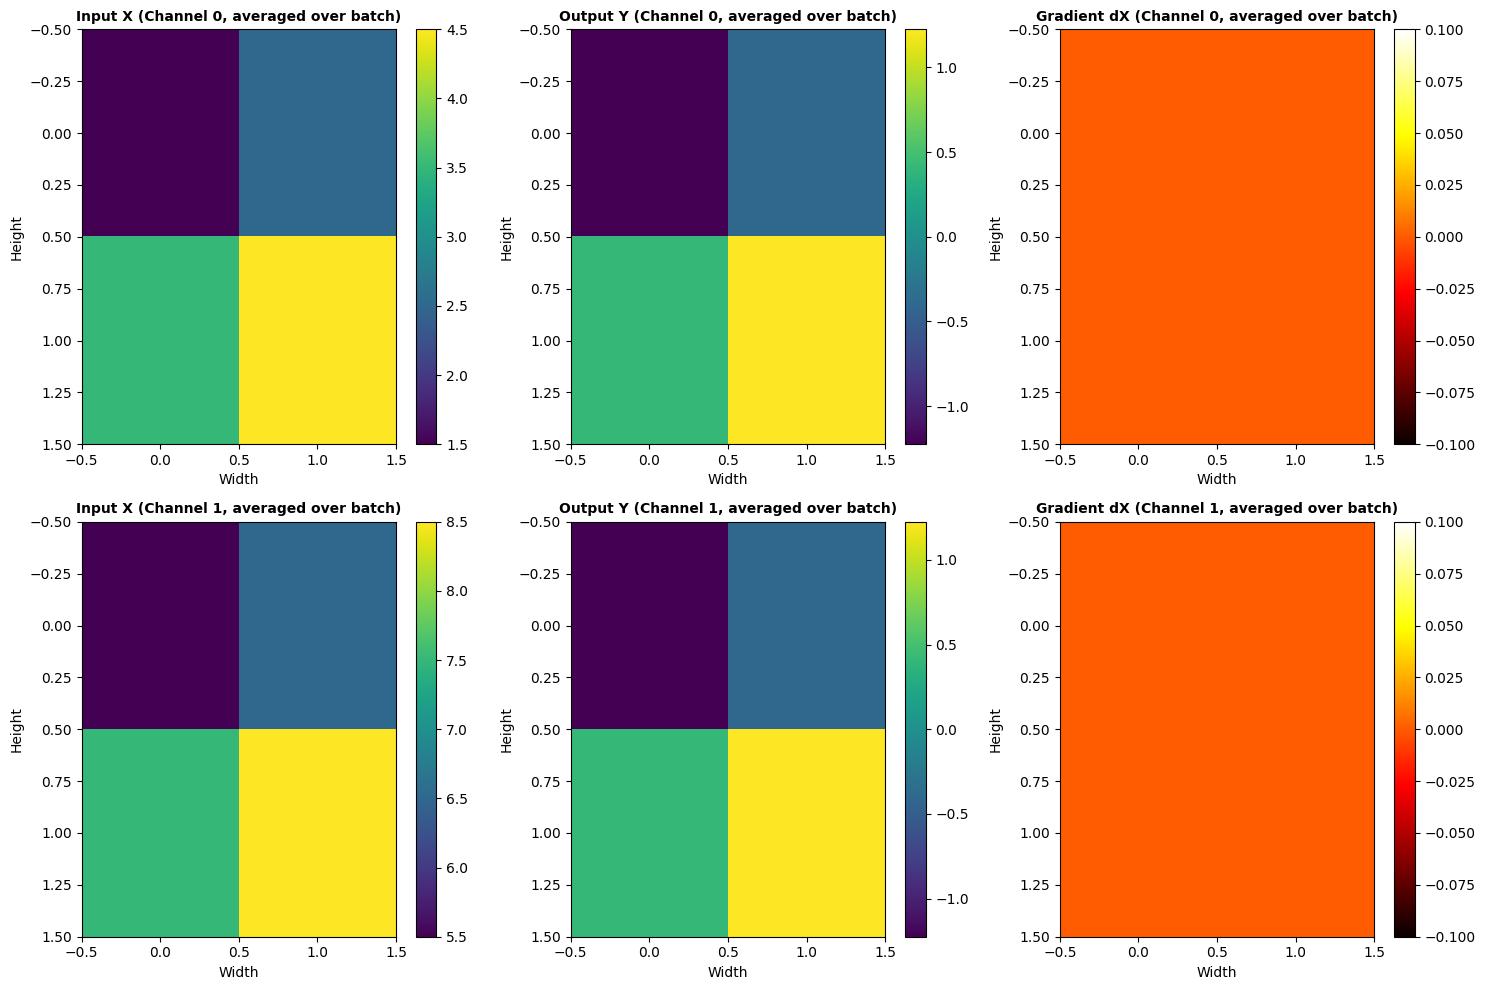


Batch Normalization Statistics:
Mean per channel: [3. 7.]
Variance per channel: [1.5 1.5]
Std per channel: [1.224749 1.224749]

Parameter Gradients:
dgamma: [0. 0.]
dbeta: [8. 8.]


In [11]:
# Visualize input, output, and gradients for each channel
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for c in range(2):
    # Input
    im1 = axes[c, 0].imshow(X[:, c, :, :].mean(axis=0), cmap='viridis', aspect='auto')
    axes[c, 0].set_title(f'Input X (Channel {c}, averaged over batch)', fontsize=10, fontweight='bold')
    axes[c, 0].set_xlabel('Width')
    axes[c, 0].set_ylabel('Height')
    plt.colorbar(im1, ax=axes[c, 0])
    
    # Output
    im2 = axes[c, 1].imshow(Y[:, c, :, :].mean(axis=0), cmap='viridis', aspect='auto')
    axes[c, 1].set_title(f'Output Y (Channel {c}, averaged over batch)', fontsize=10, fontweight='bold')
    axes[c, 1].set_xlabel('Width')
    axes[c, 1].set_ylabel('Height')
    plt.colorbar(im2, ax=axes[c, 1])
    
    # Gradient
    im3 = axes[c, 2].imshow(dX[:, c, :, :].mean(axis=0), cmap='hot', aspect='auto')
    axes[c, 2].set_title(f'Gradient dX (Channel {c}, averaged over batch)', fontsize=10, fontweight='bold')
    axes[c, 2].set_xlabel('Width')
    axes[c, 2].set_ylabel('Height')
    plt.colorbar(im3, ax=axes[c, 2])

plt.tight_layout()
plt.show()

# Print statistics
print("\nBatch Normalization Statistics:")
print(f"Mean per channel: {batchnorm.mean.flatten()}")
print(f"Variance per channel: {batchnorm.var.flatten()}")
print(f"Std per channel: {batchnorm.std.flatten()}")

print("\nParameter Gradients:")
print(f"dgamma: {batchnorm.dgamma}")
print(f"dbeta: {batchnorm.dbeta}")


## Additional Test: Different Gamma and Beta Values


In [12]:
# Test with non-zero beta and non-one gamma
X_test = np.random.randn(4, 3, 8, 8)  # 4 samples, 3 channels, 8x8
batchnorm_test = BatchNorm2D(num_channels=3, eps=1e-5)
batchnorm_test.gamma = np.array([0.5, 1.5, 2.0])
batchnorm_test.beta = np.array([0.1, -0.2, 0.3])

print("Input shape:", X_test.shape)
print("Gamma:", batchnorm_test.gamma)
print("Beta:", batchnorm_test.beta)

Y_test = batchnorm_test.forward(X_test)
print("\nOutput shape:", Y_test.shape)
print("Output mean per channel:", Y_test.mean(axis=(0, 2, 3)))
print("Output std per channel:", Y_test.std(axis=(0, 2, 3)))

dY_test = np.random.randn(*Y_test.shape)
dX_test = batchnorm_test.backward(dY_test)

print("\nGradient dX shape:", dX_test.shape)
print("dgamma:", batchnorm_test.dgamma)
print("dbeta:", batchnorm_test.dbeta)

print("\nTest passed! BatchNorm2D works correctly with different parameters.")


Input shape: (4, 3, 8, 8)
Gamma: [0.5 1.5 2. ]
Beta: [ 0.1 -0.2  0.3]

Output shape: (4, 3, 8, 8)
Output mean per channel: [ 0.1 -0.2  0.3]
Output std per channel: [0.4999975  1.49999279 1.99998859]

Gradient dX shape: (4, 3, 8, 8)
dgamma: [-11.95216347  13.23297944 -11.10736474]
dbeta: [-2.19026212 -0.73170092 -1.75594405]

Test passed! BatchNorm2D works correctly with different parameters.


## Summary

This implementation successfully demonstrates:

1. ✅ **Forward Pass**: Correctly computes batch normalization with:
   - Mean and variance computation per channel
   - Normalization: X̂ = (X - μ) / sqrt(σ² + ε)
   - Scale and shift: Y = γ * X̂ + β

2. ✅ **Backward Pass**: Correctly computes gradients:
   - **dβ** = sum(dY) over all dimensions except channel
   - **dγ** = sum(dY * X̂) over all dimensions except channel
   - **dX** = (1/m) * γ * (σ² + ε)^(-1/2) * [m*dY - sum(dY) - X̂ * sum(dY * X̂)]

3. ✅ **Numerical Example**: Verified with the provided example input

**Key Points:**
- Batch normalization normalizes activations per channel across batch and spatial dimensions
- It helps with training stability and convergence
- During backward pass, gradients flow through the normalization operation
- The implementation correctly handles the normalization statistics needed for backpropagation
